In [1]:
from pyspark import SparkConf, SparkContext
import pyspark.sql.functions as f
from pyspark.sql.functions import desc
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

## mapper1
Split the original file with space

In [2]:
def mapper1(line):
    wordlist = line.split(" ")
    maplist = []
    maplist.append(wordlist)
    return maplist

## euclidean_distance
input is ([point's coordinate], [centroid's coordinate])<br>
this mapper calculates the euclidean distance between the points and centroids

In [3]:
def euclidean_distance(line):
    maplist = []
    total = 0
    for d in range(58):
        total += (float(line[0][0][d]) - float(line[1][0][d])) ** 2
    #total = total ** 0.5
    maplist.append((line[0][1], (line[0][0], line[1][0], line[1][1], total)))
    return maplist

## manhattan_distance
input is ([point's coordinate], [centroid's coordinate])<br>
this mapper calculates the manhattan distance between the points and centroids

In [4]:
def manhattan_distance(line):
    maplist = []
    total = 0
    for d in range(58):
        total += abs(float(line[0][0][d]) - float(line[1][0][d]))
    maplist.append((line[0][1], (line[0][0], line[1][0], line[1][1], total)))
    return maplist

## reducer1
this reducer compares the distances of one point(which is the key), and take the shorter distance as result

In [5]:
def reducer1(x, y):
    if x[3] <= y[3]:
        return x
    else:
        return y

## distance_only
a mapper to take the distance to calculate costs

In [6]:
def distance_only(line):
    maplist = []
    maplist.append(line[1][3])
    return maplist

## mapper2
input is (point's index, ([point's coordinate], [centroid's coordinate], centroid's index, distance))<br>
output is (centroid's index, ([point's coordinate], point's index))

In [7]:
def mapper2(line):
    maplist = []
    maplist.append((line[1][2], (line[1][0], 1)))
    return maplist

## reducer2
this reducer add all the coordinates of the point and the count of how many points in total

In [8]:
def reducer2(x, y):
    maplist = []
    for d in range(58):
        maplist.append(str(float(x[0][d]) + float(y[0][d])))
    return (maplist, float(x[1]) + float(y[1]))

## mapper3
input is (sum of total coordinates, count of total points in the cluster)<br>
output is (new coordinate, cluster's index)

In [9]:
def mapper3(line):
    maplist = []
    for d in range(58):
        maplist.append(str(float(line[1][0][d])/float(line[1][1])))
    tmplist = []
    tmplist.append((maplist, line[0]))
    return tmplist

## .flatMap(mapper1).zipWithIndex()
give every points an index
## points_centroids = dataFile.cartesian(centroids1)
combine the centroids coordinate so is more convenient to calcualte
## cost = d.reduce(lambda x, y: x + y)
d is a rdd with the distance of each points, this reduce function add them up

,C1,C2
1,6.236603e+08,4.387478e+08
2,5.098629e+08,2.498039e+08
3,4.854807e+08,1.944948e+08
4,4.639970e+08,1.698048e+08
5,4.609693e+08,1.562957e+08
6,4.605378e+08,1.490942e+08
7,4.603131e+08,1.425085e+08
8,4.600035e+08,1.323039e+08
9,4.595705e+08,1.171710e+08
10,4.590211e+08,1.085474e+08


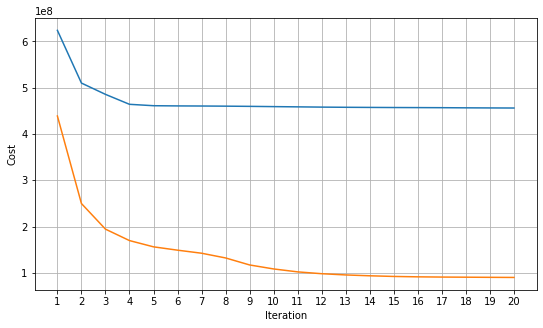

In [19]:
sc.stop()
conf = SparkConf().setMaster("local").setAppName("wordcount")
sc = SparkContext(conf=conf)

MAX_ITER = 20
k = 10
phi = sc.accumulator(0)
DIM = 58

dataFile = sc.textFile("data.txt").flatMap(mapper1).zipWithIndex()
centroids1 = sc.textFile("c1.txt").flatMap(mapper1).zipWithIndex()
centroids2 = sc.textFile("c2.txt").flatMap(mapper1).zipWithIndex()

#print(centroids1.collect()[1])

totalCosts = []
totalCosts_c2 = []

centroids_dist_c1_euclidean = []
centroids_dist_c1_manhattan = []
centroids_dist_c2_euclidean = []
centroids_dist_c2_manhattan = []

for i in range(20):
    
    points_centroids = dataFile.cartesian(centroids1)
    #print(points_centroids.collect()[1])
    points_centroids_distance = points_centroids.flatMap(euclidean_distance)
    assigned_centroids = points_centroids_distance.reduceByKey(reducer1)
    #print(assigned_centroids.take(20))
    d = assigned_centroids.flatMap(distance_only)
    #print(d.collect())
    cost = d.reduce(lambda x, y: x + y)
    
    #print(cost)
    totalCosts.append(cost)
    
    new_assigned_centroids = assigned_centroids.flatMap(mapper2)
    #print(new_assigned_centroids.collect()[3000])
    new2_assigned_centroids = new_assigned_centroids.reduceByKey(reducer2)
    #print(new2_assigned_centroids.collect()[0])
    if i < 20:
        centroids1 = new2_assigned_centroids.flatMap(mapper3)

    #print(centroids1.collect()[1])
    #print(totalCosts)

for i in range(20):
    points_centroids2 = dataFile.cartesian(centroids2)
    #print(points_centroids.collect()[0])
    #print(points_centroids.collect()[1])
    points_centroids_distance2 = points_centroids2.flatMap(euclidean_distance)
    #print(points_centroids_distance.collect()[0])
    #print(points_centroids_distance.collect()[1])
    assigned_centroids2 = points_centroids_distance2.reduceByKey(reducer1)
    #print(assigned_centroids.collect()[3000])
    d = assigned_centroids2.flatMap(distance_only)
    #print(d.collect())
    cost2 = d.reduce(lambda x, y: x + y)
    
    #print(cost2)
    totalCosts_c2.append(cost2)
    
    new_assigned_centroids2 = assigned_centroids2.flatMap(mapper2)
    #print(new_assigned_centroids.collect()[3000])
    new2_assigned_centroids2 = new_assigned_centroids2.reduceByKey(reducer2)
    #print(new2_assigned_centroids.collect()[0])
    if i < 20:
        centroids2 = new2_assigned_centroids2.flatMap(mapper3)
    #print(centroids1.collect()[1])
    #print(totalCosts_c2)

x_label = []
index_tmp = []

for i in range(20):
    index_tmp.append(i+1) 

df = pd.DataFrame(list(zip(totalCosts, totalCosts_c2)), columns =['C1', 'C2'], index = index_tmp) 
display(df)

for i in range(20):
    x_label.append(str(i+1))

plt.figure(figsize=(9, 5))
plt.grid(True)
plt.plot(x_label, totalCosts)
plt.plot(x_label, totalCosts_c2)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

    
#sc.stop()

## centroids1 = centroids1.sortBy(lambda x: x[1])
sort the centroids according to their index

In [21]:

centroids1 = centroids1.sortBy(lambda x: x[1])
centroids2 = centroids2.sortBy(lambda x: x[1])
#print(centroids1.collect())

#print(centroids1.collect())
maplist1 = []
maplist2 = []
maplist3 = []
maplist4 = []

# C1 euclidean
for key1, value1 in centroids1.collect():
    tmplist1 = []
    for key2, value2 in centroids1.collect():
        total = 0
        if value1 < value2:
            for d in range(58):
                total += (float(key1[d]) - float(key2[d])) ** 2
            total = total ** 0.5
            tmplist1.append(total)
        elif value1 == value2:
            tmplist1.append(0.0)
        else:
            tmplist1.append(" ")
    #print(tmplist)
    maplist1.append(tmplist1)

df1 = pd.DataFrame(maplist1, columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], index = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']) 
display(df1)

# C2 euclidean 
for key1, value1 in centroids2.collect():
    tmplist2 = []
    for key2, value2 in centroids2.collect():
        total = 0
        if value1 < value2:
            for d in range(58):
                total += (float(key1[d]) - float(key2[d])) ** 2
            total = total ** 0.5
            tmplist2.append(total)
        elif value1 == value2:
            tmplist2.append(0.0)
        else:
            tmplist2.append(" ")
    maplist2.append(tmplist2)

df2 = pd.DataFrame(maplist2, columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], index = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']) 
display(df2)

# C1 manhattan
for key1, value1 in centroids1.collect():
    tmplist3 = []
    for key2, value2 in centroids1.collect():
        total = 0
        if value1 < value2:
            for d in range(58):
                total += abs(float(key1[d]) - float(key2[d]))
            tmplist3.append(total)
        elif value1 == value2:
            tmplist3.append(0.0)
        else:
            tmplist3.append(" ")
    #print(tmplist)
    maplist3.append(tmplist3)

df3 = pd.DataFrame(maplist3, columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], index = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']) 
display(df3)

# C2 manhattan
for key1, value1 in centroids2.collect():
    tmplist4 = []
    for key2, value2 in centroids2.collect():
        total = 0
        if value1 < value2:
            for d in range(58):
                total += abs(float(key1[d]) - float(key2[d]))
            tmplist4.append(total)
        elif value1 == value2:
            tmplist4.append(0.0)
        else:
            tmplist4.append(" ")
    #print(tmplist)
    maplist4.append(tmplist4)

df4 = pd.DataFrame(maplist4, columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], index = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']) 
display(df4)


,1,2,3,4,5,6,7,8,9,10
1,0,692.158,3490.26,205.75,346.719,512.612,444.731,566.202,1282.77,307.669128
2,,0,2798.8,897.659,1038.83,1204.08,1136.33,1257.45,669.89,412.076077
3,,,0,3695.11,3836.91,4002.69,3934.87,4056.14,2294.58,3195.923901
4,,,,0,142.439,309.506,241.73,363.263,1474.95,504.634116
5,,,,,0,167.15,99.5455,220.902,1615.85,646.930564
6,,,,,,0,67.9119,53.7899,1782.2,814.076150
7,,,,,,,0,121.634,1715.25,746.335559
8,,,,,,,,0,1835.64,867.823079
9,,,,,,,,,0,975.320423
10,,,,,,,,,,0.000000


,1,2,3,4,5,6,7,8,9,10
1,0,15760.1,14110.8,9045.32,5567.68,1924.62,1100.86,402.891,2105.44,3169.003773
2,,0,11524.5,6743.88,10192.5,14455.1,14682.5,15362.4,13674.7,12597.039560
3,,,0,9545.88,10883.4,12234,13208,13786.5,12509,11938.376127
4,,,,0,3494.22,7718.22,7957.78,8644.81,6947.82,5876.330200
5,,,,,0,4404.56,4492.46,5169.94,3488.16,2407.918794
6,,,,,,0,1182.86,1615.79,1313.33,2153.771472
7,,,,,,,0,698.488,1010.2,2085.460676
8,,,,,,,,0,1702.79,2768.607719
9,,,,,,,,,0,1080.534944
10,,,,,,,,,,0.000000


,1,2,3,4,5,6,7,8,9,10
1,0,728.924,3797.9,212.181,374.89,577.402,499.158,645.77,1731.06,406.701225
2,,0,3072.89,935.885,1100.83,1303.9,1225.35,1372.09,1005.29,490.928058
3,,,0,4001.04,4170.3,4372.79,4294.95,4440.72,2513.42,3396.420003
4,,,,0,171.365,375.248,296.255,443.498,1934.09,609.749322
5,,,,,0,204.523,125.597,272.935,2102.86,779.397227
6,,,,,,0,79.4017,69.5899,2306.38,983.019681
7,,,,,,,0,147.866,2227.56,904.370250
8,,,,,,,,0,2374.55,1050.916221
9,,,,,,,,,0,1327.583980
10,,,,,,,,,,0.000000


,1,2,3,4,5,6,7,8,9,10
1,0,15772.6,20215.6,9533.17,5604.2,3088.05,1311.04,471.266,2369.41,3349.657086
2,,0,16003.5,7219.2,10221,16105.3,14909.2,15434.5,13950.6,12776.883065
3,,,0,10690.5,14613.6,17509.9,18912.6,19748.9,17851.8,16873.243674
4,,,,0,3935.29,8896.39,8228.36,9065.4,7168.73,6190.679312
5,,,,,0,5893.07,4696.98,5221.25,3737.71,2564.170543
6,,,,,,0,1781.82,2619.81,2162.8,3337.746261
7,,,,,,,0,840.723,1068.94,2137.788257
8,,,,,,,,0,1901.21,2883.734537
9,,,,,,,,,0,1176.450426
10,,,,,,,,,,0.000000


,C1,C2
1,550117.142000,1.433739e+06
2,464869.275879,1.084489e+06
3,470897.382277,9.734317e+05
4,483914.409173,8.959346e+05
5,489216.071003,8.651283e+05
6,487629.668550,8.458466e+05
7,483711.923214,8.272196e+05
8,475330.773493,8.035903e+05
9,474871.238846,7.560395e+05
10,457232.920115,7.173329e+05


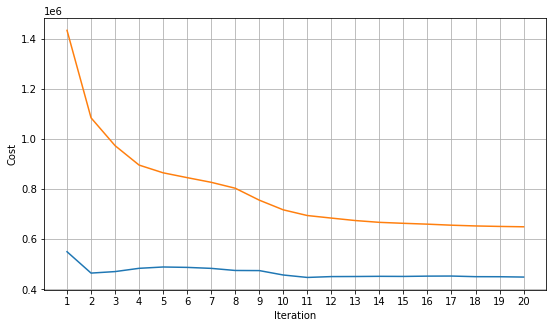

In [24]:
sc.stop()
conf = SparkConf().setMaster("local").setAppName("wordcount")
sc = SparkContext(conf=conf)

MAX_ITER = 20
k = 10
phi = sc.accumulator(0)
DIM = 58

dataFile = sc.textFile("data.txt").flatMap(mapper1).zipWithIndex()
centroids1 = sc.textFile("c1.txt").flatMap(mapper1).zipWithIndex()
centroids2 = sc.textFile("c2.txt").flatMap(mapper1).zipWithIndex()

#print(centroids1.collect()[1])

totalCosts = []
totalCosts_c2 = []

centroids_dist_c1_euclidean = []
centroids_dist_c1_manhattan = []
centroids_dist_c2_euclidean = []
centroids_dist_c2_manhattan = []

for i in range(20):
    points_centroids = dataFile.cartesian(centroids1)
    #print(points_centroids.collect()[1])
    points_centroids_distance = points_centroids.flatMap(manhattan_distance)
    assigned_centroids = points_centroids_distance.reduceByKey(reducer1)
    #print(assigned_centroids.take(20))
    d = assigned_centroids.flatMap(distance_only)
    #print(d.collect())
    cost = d.reduce(lambda x, y: x + y)
    
    #print(cost)
    totalCosts.append(cost)
    
    new_assigned_centroids = assigned_centroids.flatMap(mapper2)
    #print(new_assigned_centroids.collect()[3000])
    new2_assigned_centroids = new_assigned_centroids.reduceByKey(reducer2)
    #print(new2_assigned_centroids.collect()[0])
    if i < 20:
        centroids1 = new2_assigned_centroids.flatMap(mapper3)
    
    '''
    if i == 19:
        centroids_c1_cart = centroids1.cartesian(centroids1)
        centroids_c1_cart_euclidean = centroids_c1_cart.flatMap(calculate_dist_euclidean)
        print("c1:")
        print(centroids_c1_cart_euclidean.collect())
    '''

    #print(centroids1.collect()[1])
    #print(totalCosts)


for i in range(20):
    points_centroids2 = dataFile.cartesian(centroids2)
    #print(points_centroids.collect()[0])
    #print(points_centroids.collect()[1])
    points_centroids_distance2 = points_centroids2.flatMap(manhattan_distance)
    #print(points_centroids_distance.collect()[0])
    #print(points_centroids_distance.collect()[1])
    assigned_centroids2 = points_centroids_distance2.reduceByKey(reducer1)
    #print(assigned_centroids.collect()[3000])
    d = assigned_centroids2.flatMap(distance_only)
    #print(d.collect())
    cost2 = d.reduce(lambda x, y: x + y)
    
    #print(cost2)
    totalCosts_c2.append(cost2)
    
    new_assigned_centroids2 = assigned_centroids2.flatMap(mapper2)
    #print(new_assigned_centroids.collect()[3000])
    new2_assigned_centroids2 = new_assigned_centroids2.reduceByKey(reducer2)
    #print(new2_assigned_centroids.collect()[0])
    if i < 20:
        centroids2 = new2_assigned_centroids2.flatMap(mapper3)
    #print(centroids1.collect()[1])
    #print(totalCosts_c2)
    
x_label = []
index_tmp = []

for i in range(20):
    index_tmp.append(i+1) 

df = pd.DataFrame(list(zip(totalCosts, totalCosts_c2)), columns =['C1', 'C2'], index = index_tmp) 
display(df)

for i in range(20):
    x_label.append(str(i+1))

plt.figure(figsize=(9, 5))
plt.plot(x_label, totalCosts)
plt.plot(x_label, totalCosts_c2)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

    

In [25]:

centroids1 = centroids1.sortBy(lambda x: x[1])
centroids2 = centroids2.sortBy(lambda x: x[1])
#print(centroids1.collect())

#print(centroids1.collect())
maplist1 = []
maplist2 = []
maplist3 = []
maplist4 = []

# C1 euclidean
for key1, value1 in centroids1.collect():
    tmplist1 = []
    for key2, value2 in centroids1.collect():
        total = 0
        if value1 < value2:
            for d in range(58):
                total += (float(key1[d]) - float(key2[d])) ** 2
            total = total ** 0.5
            tmplist1.append(total)
        elif value1 == value2:
            tmplist1.append(0.0)
        else:
            tmplist1.append(" ")
    #print(tmplist)
    maplist1.append(tmplist1)

df1 = pd.DataFrame(maplist1, columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], index = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']) 
display(df1)

# C2 euclidean 
for key1, value1 in centroids2.collect():
    tmplist2 = []
    for key2, value2 in centroids2.collect():
        total = 0
        if value1 < value2:
            for d in range(58):
                total += (float(key1[d]) - float(key2[d])) ** 2
            total = total ** 0.5
            tmplist2.append(total)
        elif value1 == value2:
            tmplist2.append(0.0)
        else:
            tmplist2.append(" ")
    maplist2.append(tmplist2)

df2 = pd.DataFrame(maplist2, columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], index = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']) 
display(df2)

# C1 manhattan
for key1, value1 in centroids1.collect():
    tmplist3 = []
    for key2, value2 in centroids1.collect():
        total = 0
        if value1 < value2:
            for d in range(58):
                total += abs(float(key1[d]) - float(key2[d]))
            tmplist3.append(total)
        elif value1 == value2:
            tmplist3.append(0.0)
        else:
            tmplist3.append(" ")
    #print(tmplist)
    maplist3.append(tmplist3)

df3 = pd.DataFrame(maplist3, columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], index = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']) 
display(df3)

# C2 manhattan
for key1, value1 in centroids2.collect():
    tmplist4 = []
    for key2, value2 in centroids2.collect():
        total = 0
        if value1 < value2:
            for d in range(58):
                total += abs(float(key1[d]) - float(key2[d]))
            tmplist4.append(total)
        elif value1 == value2:
            tmplist4.append(0.0)
        else:
            tmplist4.append(" ")
    #print(tmplist)
    maplist4.append(tmplist4)

df4 = pd.DataFrame(maplist4, columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], index = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']) 
display(df4)

,1,2,3,4,5,6,7,8,9,10
1,0,2219.18,9948.04,528.7,413.365,827.719,681.035,917.127,832.147,729.056349
2,,0,7767.95,2734.05,2628.49,3044.48,2898.71,3133.46,1812.45,1491.357346
3,,,0,10433.1,10361.4,10773.5,10626.5,10863,9340.28,9236.840022
4,,,,0,221.373,375.156,249.379,457.26,1156.58,1251.158346
5,,,,,0,415.99,270.749,505.071,1171.96,1137.135266
6,,,,,,0,147.047,89.4909,1529.46,1553.123807
7,,,,,,,0,236.515,1391.55,1407.404400
8,,,,,,,,0,1613.56,1642.128687
9,,,,,,,,,0,709.407786
10,,,,,,,,,,0.000000


,1,2,3,4,5,6,7,8,9,10
1,0,15747.2,14100.1,9032.33,5554.79,2006.7,1338.16,514.627,1571.24,3022.660884
2,,0,11524.5,6743.88,10192.5,14474.6,14412.1,15239.9,14328.2,12731.397635
3,,,0,9545.88,10883.4,12167.8,13125.4,13684.6,12644,12006.394618
4,,,,0,3494.22,7742.63,7694.28,8521.2,7588.4,6009.820223
5,,,,,0,4452.97,4219.76,5047.52,4167.64,2542.569354
6,,,,,,0,1405.11,1637.73,910.994,2124.263362
7,,,,,,,0,827.841,566.551,1684.516012
8,,,,,,,,0,1081.38,2511.458859
9,,,,,,,,,0,1649.389172
10,,,,,,,,,,0.000000


,1,2,3,4,5,6,7,8,9,10
1,0,2341.02,11929.3,651.187,496.332,947.743,770.737,1056.8,1260.51,737.713573
2,,0,9597.44,2778.95,2830.14,3280.36,3104.29,3388.98,2380.46,1605.270129
3,,,0,12323.3,12421.3,12871.5,12695.6,12979.1,10775.9,11196.786982
4,,,,0,335.951,558.469,382.463,667.533,1653.83,1379.165173
5,,,,,0,452.861,276.326,561.849,1755.11,1226.660355
6,,,,,,0,177.593,110.218,2205.31,1677.666864
7,,,,,,,0,287.43,2028.9,1500.993410
8,,,,,,,,0,2314.67,1786.811316
9,,,,,,,,,0,1006.367826
10,,,,,,,,,,0.000000


,1,2,3,4,5,6,7,8,9,10
1,0,15757.7,20200.3,9517.67,5588.85,3281.49,1430.21,602.955,2102.55,3211.455756
2,,0,16003.5,7219.2,10221,16325.3,14506.5,15336,14980.1,12922.931357
3,,,0,10690.5,14613.6,17521.5,18775.1,19602.3,18111.9,16995.133536
4,,,,0,3935.29,9116.02,8090.51,8918.81,7771.22,6312.530012
5,,,,,0,6110.83,4293.5,5123.07,4768.92,2710.056500
6,,,,,,0,1855.58,2682.57,1358.8,3413.036179
7,,,,,,,0,833.43,674.828,1784.512045
8,,,,,,,,0,1500.82,2613.997305
9,,,,,,,,,0,2062.251068
10,,,,,,,,,,0.000000


In [ ]:
sc.stop()